# Data Analysis 3 - Home Assignment 3
## Author: Márton Nagy

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import dill
import json
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from plotnine import *
from IPython.display import display
import patchworklib as pw
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import percent_format
%matplotlib inline

color = ["#DB5461", "#080357", "#3B8EA5", "#3B8EA5", "#3B8EA5"]

import statsmodels
import patsy
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima.arima import auto_arima
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import holidays
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller


Reading raw datafile.

In [153]:
data = pd.read_csv('data.csv')

Converting to datetime.

In [154]:
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')

We can see that there are no missing values.

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24592 entries, 0 to 24591
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ts      24592 non-null  datetime64[ns]
 1   v1      24592 non-null  float64       
 2   v2      24592 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 576.5 KB


But are there missing periods? It turns out, that 248 hour-level observations are missing from the data. As some models cannot deal with gaps, we will have to deal with this.

In [156]:
full_range = pd.date_range(start=data['ts'].min(), end=data['ts'].max(), freq='H')
missing_timestamps = set(full_range) - set(data['ts'])
missing_timestamps

{Timestamp('2022-03-27 02:00:00'),
 Timestamp('2022-04-29 22:00:00'),
 Timestamp('2022-04-29 23:00:00'),
 Timestamp('2022-05-20 21:00:00'),
 Timestamp('2022-05-20 22:00:00'),
 Timestamp('2022-05-20 23:00:00'),
 Timestamp('2022-05-21 18:00:00'),
 Timestamp('2022-05-21 19:00:00'),
 Timestamp('2022-05-21 20:00:00'),
 Timestamp('2022-05-21 21:00:00'),
 Timestamp('2022-05-21 22:00:00'),
 Timestamp('2022-05-21 23:00:00'),
 Timestamp('2022-06-27 00:00:00'),
 Timestamp('2022-06-27 01:00:00'),
 Timestamp('2022-06-27 02:00:00'),
 Timestamp('2022-06-27 03:00:00'),
 Timestamp('2022-06-27 04:00:00'),
 Timestamp('2022-06-27 05:00:00'),
 Timestamp('2022-06-27 06:00:00'),
 Timestamp('2022-06-27 07:00:00'),
 Timestamp('2022-06-27 08:00:00'),
 Timestamp('2022-06-27 09:00:00'),
 Timestamp('2022-06-27 10:00:00'),
 Timestamp('2022-06-27 11:00:00'),
 Timestamp('2022-06-27 12:00:00'),
 Timestamp('2022-06-27 13:00:00'),
 Timestamp('2022-06-27 14:00:00'),
 Timestamp('2022-06-27 15:00:00'),
 Timestamp('2022-06-

I add the missing observations to my dataset (thus I will now have NAs in v1 and v2 - 248 times in total, that is about 1% of the dataset).

In [ ]:
data = data.set_index('ts').reindex(full_range).reset_index()
data.rename(columns={'index': 'ts'}, inplace=True)

In [ ]:
data.v1.isna().sum()

As we now have all the timestamps in the dataset, we can add seasonal dummies (for months, quarters, days, hours, days of week, weekends, and holidays). I also create a linear trendline.

In [ ]:
data['year'] = data['ts'].dt.year
data['month'] = data['ts'].dt.month
data['quarter'] = data['ts'].dt.quarter
data['day'] = data['ts'].dt.day
data['hour'] = data['ts'].dt.hour
data['dow'] = data['ts'].dt.dayofweek + 1
data['weekend'] = data['dow'].apply(lambda x: 1 if x in [6, 7] else 0)
hu_holidays = holidays.Hungary(years = [x for x in range(int(data.year.min()), int(data.year.max()) + 1, 1)])
holidates =  [x[0] for x in hu_holidays.items()]
data['is_holiday'] = data['ts'].apply(lambda x: 1 if x.date() in holidates else 0)
data['trend'] = data.index + 1

The way I deal with the missing values is rather simple: I impute them with the average value for that month-day-hour of the non-missing years. This is a sensible, but rather naive approach - but it is much better than simple linear interpolation, as this way we will have the seasonal patterns present in our imputed values as well.

Another approach for the imputations could be to use the Prophet package (as it can handle missing values), and impute the missing values with the predicted values of the Prophet model. I will do this later (after having selected the best performing Prophet specification through cross-validation), and then for the other models (which cannot handle missing data) I will cross-validate which imputation method provides the more accurate results.

In [161]:
data = data.set_index('ts')

hourly_avg_v1 = data.groupby(['month', 'day', 'hour'])['v1'].mean()
hourly_avg_v2 = data.groupby(['month', 'day', 'hour'])['v2'].mean()

def impute_with_hourly_avg(row):
    if pd.isna(row['v1']):
        avg_v1 = hourly_avg_v1.get((row['month'], row['day'], row['hour']), np.nan)
        row['v1_imputed'] = avg_v1 if not np.isnan(avg_v1) else np.nan
    else:
        row['v1_imputed'] = row['v1']

    if pd.isna(row['v2']):
        avg_v2 = hourly_avg_v2.get((row['month'], row['day'], row['hour']), np.nan)
        row['v2_imputed'] = avg_v2 if not np.isnan(avg_v2) else np.nan
    else:
        row['v2_imputed'] = row['v2']
    
    return row

data = data.apply(impute_with_hourly_avg, axis=1)
data = data.reset_index()


I also create a flag for when I made an imputation.

In [169]:
data['na_flag'] = data['v1'].isna().astype(int)

Now let's check some plots about the time series. This may give us some ideas about what kind of seasonal effects are in play.

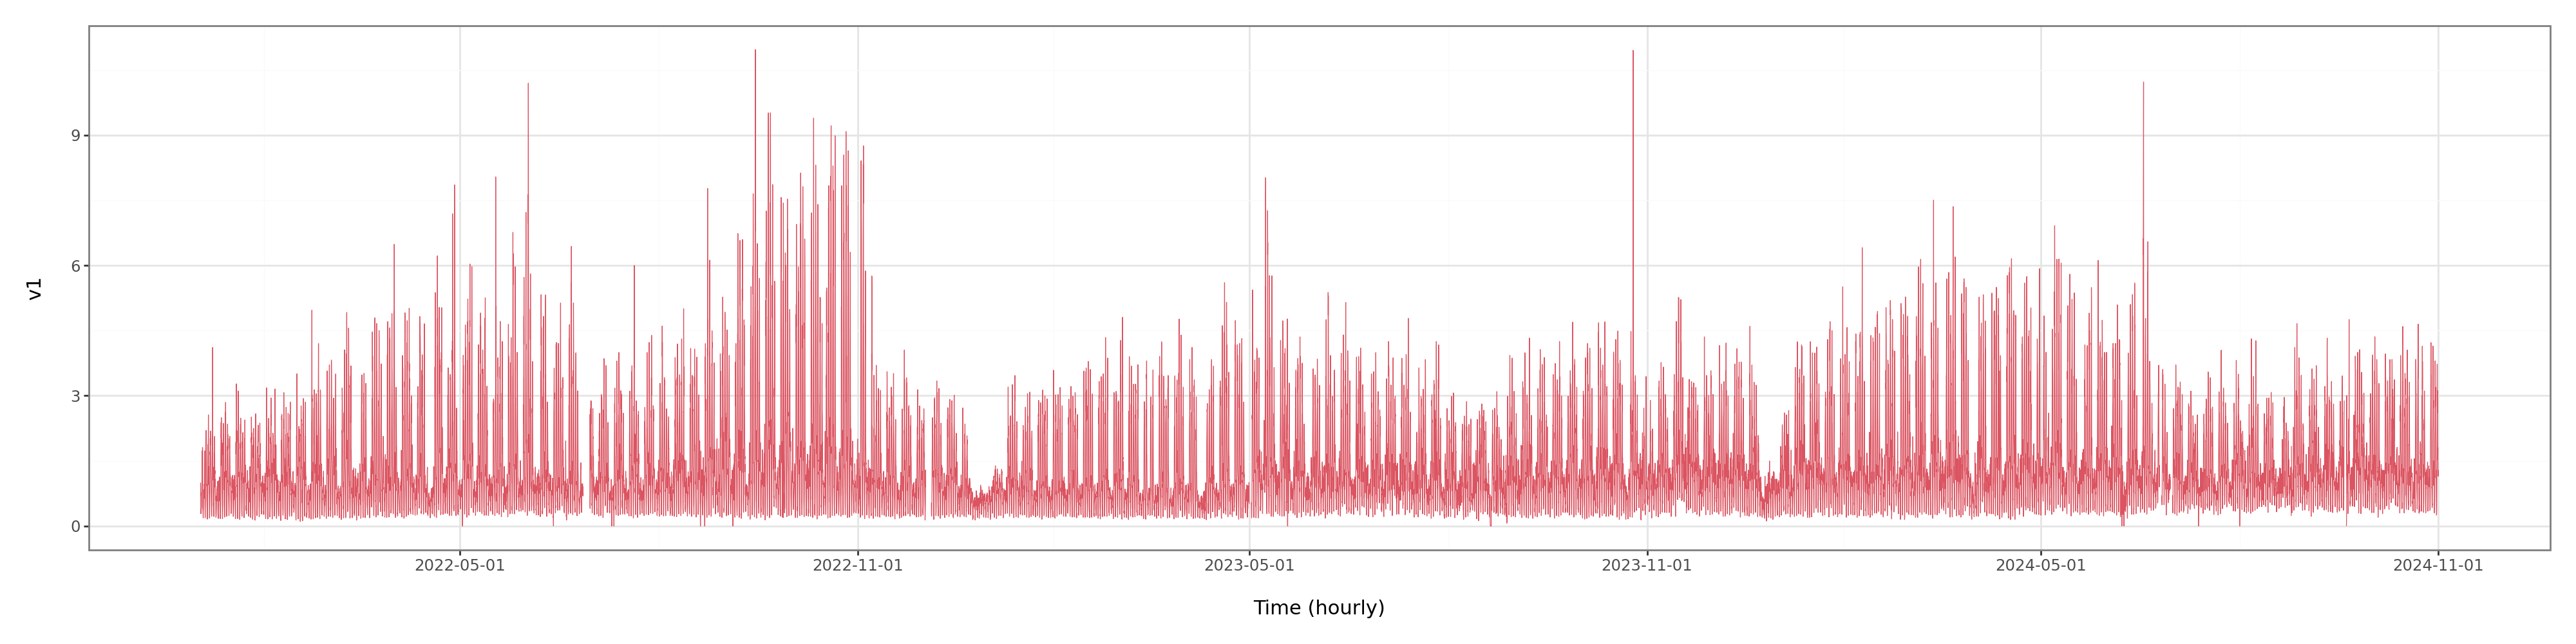

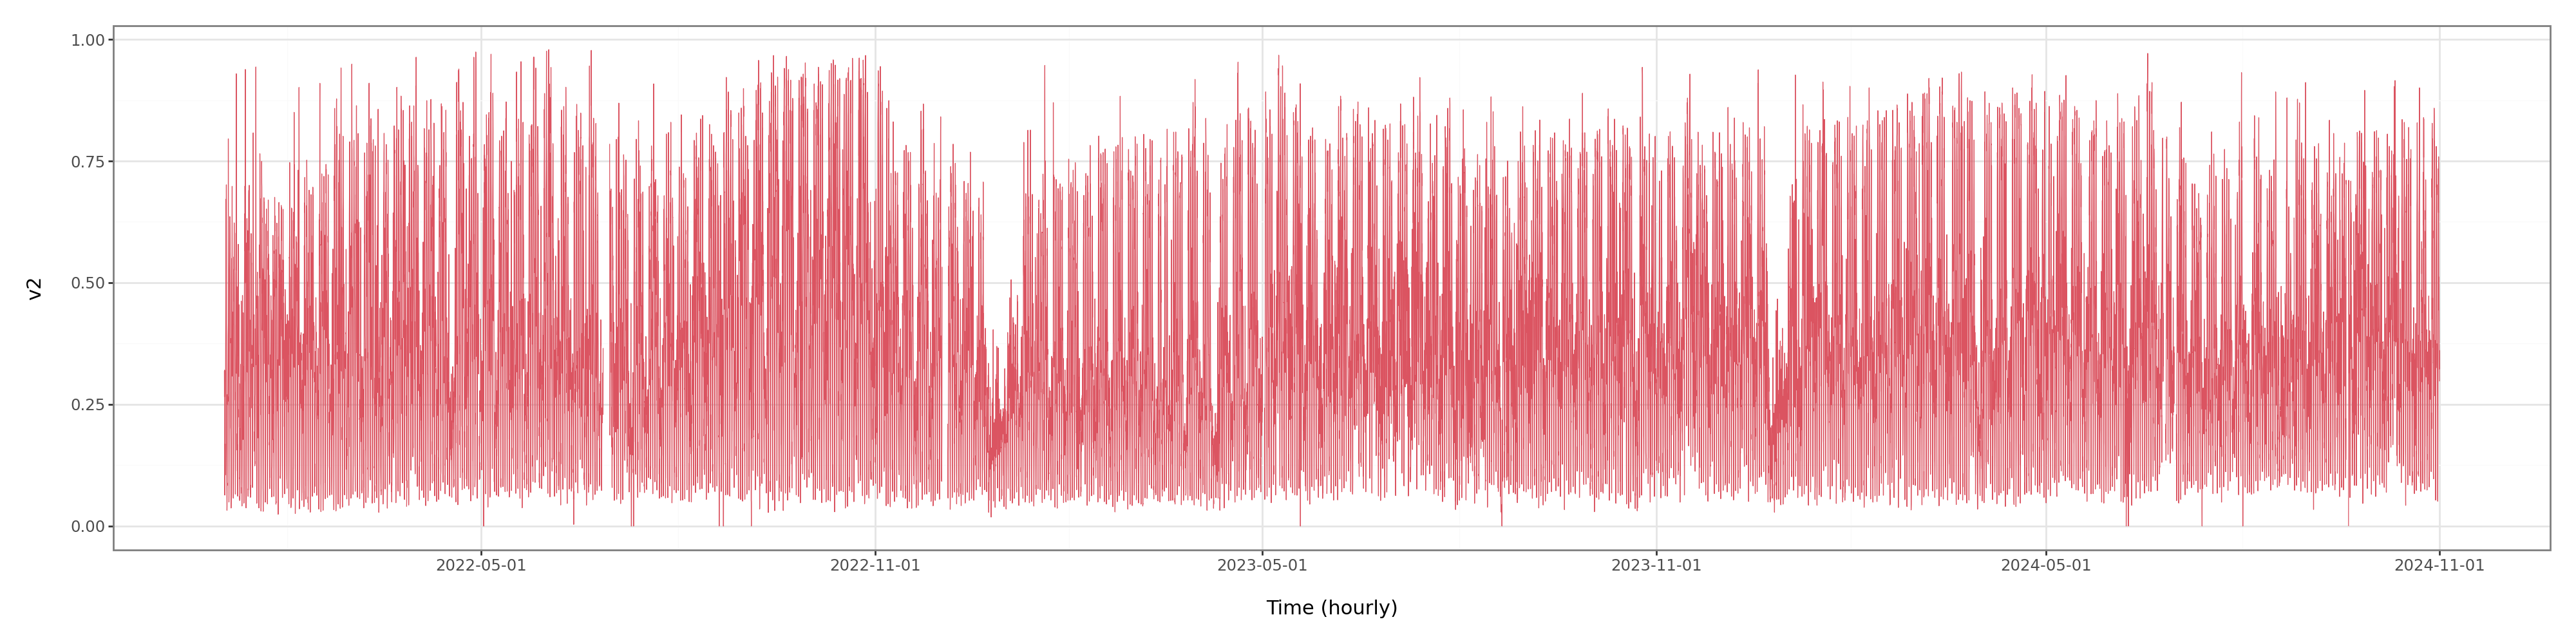

In [163]:
display(
    ggplot(data, aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)

display(
    ggplot(data, aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)

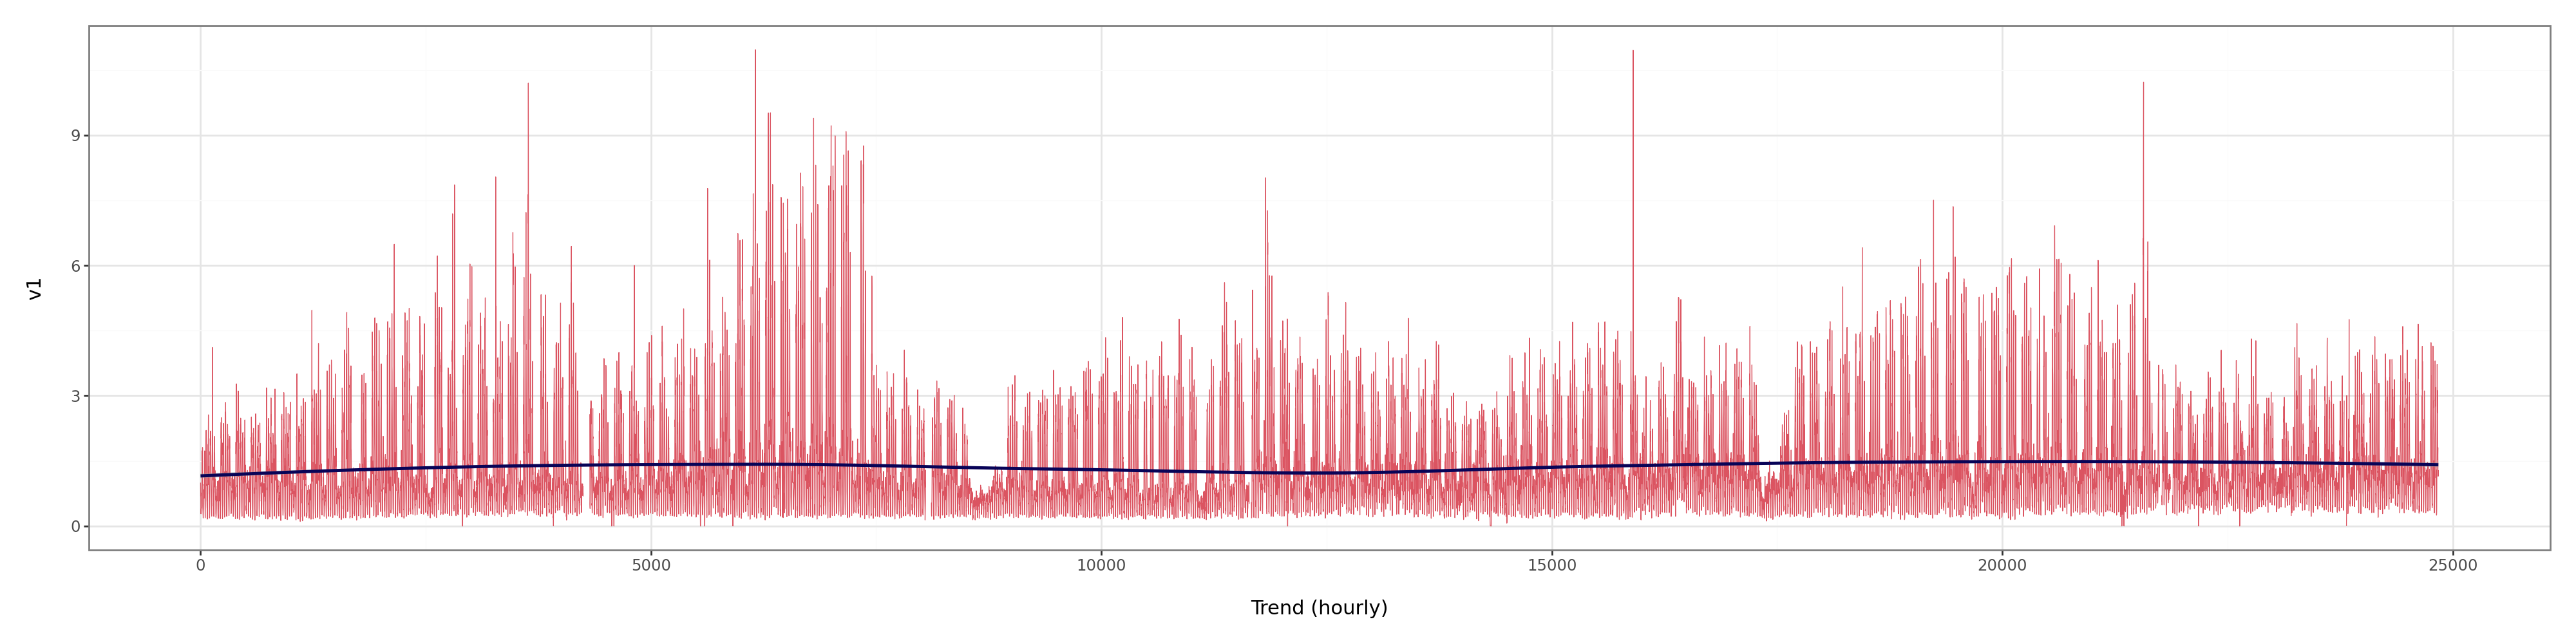

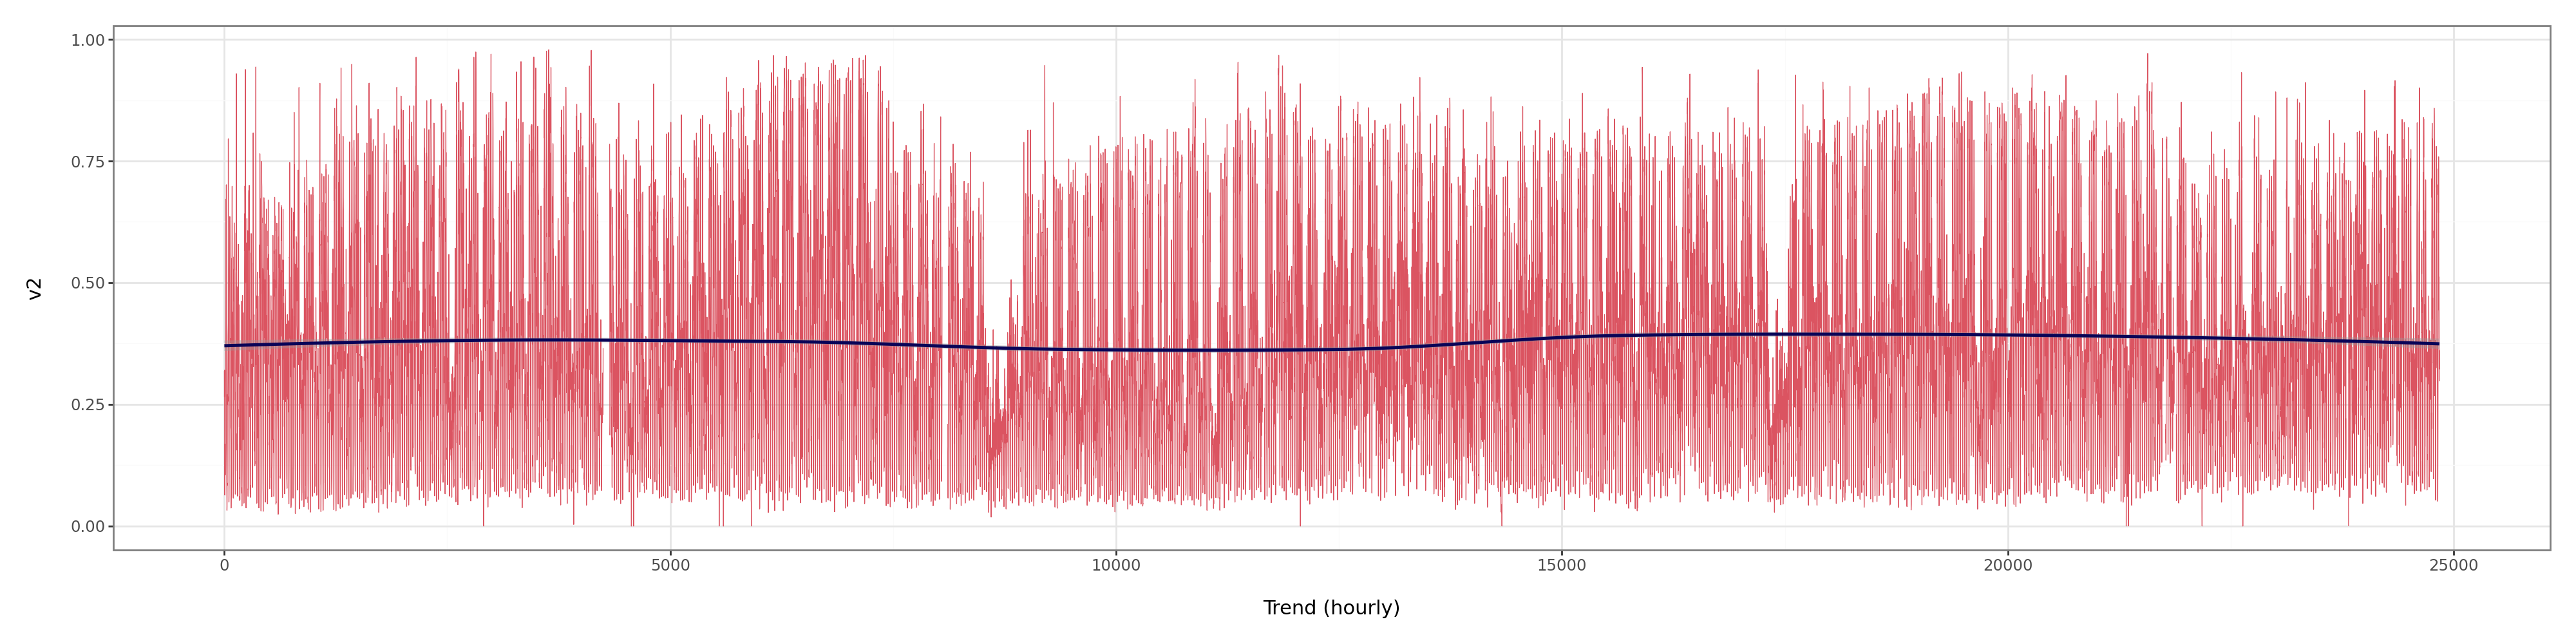

In [164]:
display(
    ggplot(data, aes(x='trend', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + geom_smooth(method='loess', color=color[1], size=1)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Trend (hourly)')
)

display(
    ggplot(data, aes(x='trend', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + geom_smooth(method='loess', color=color[1], size=1)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Trend (hourly)')
)

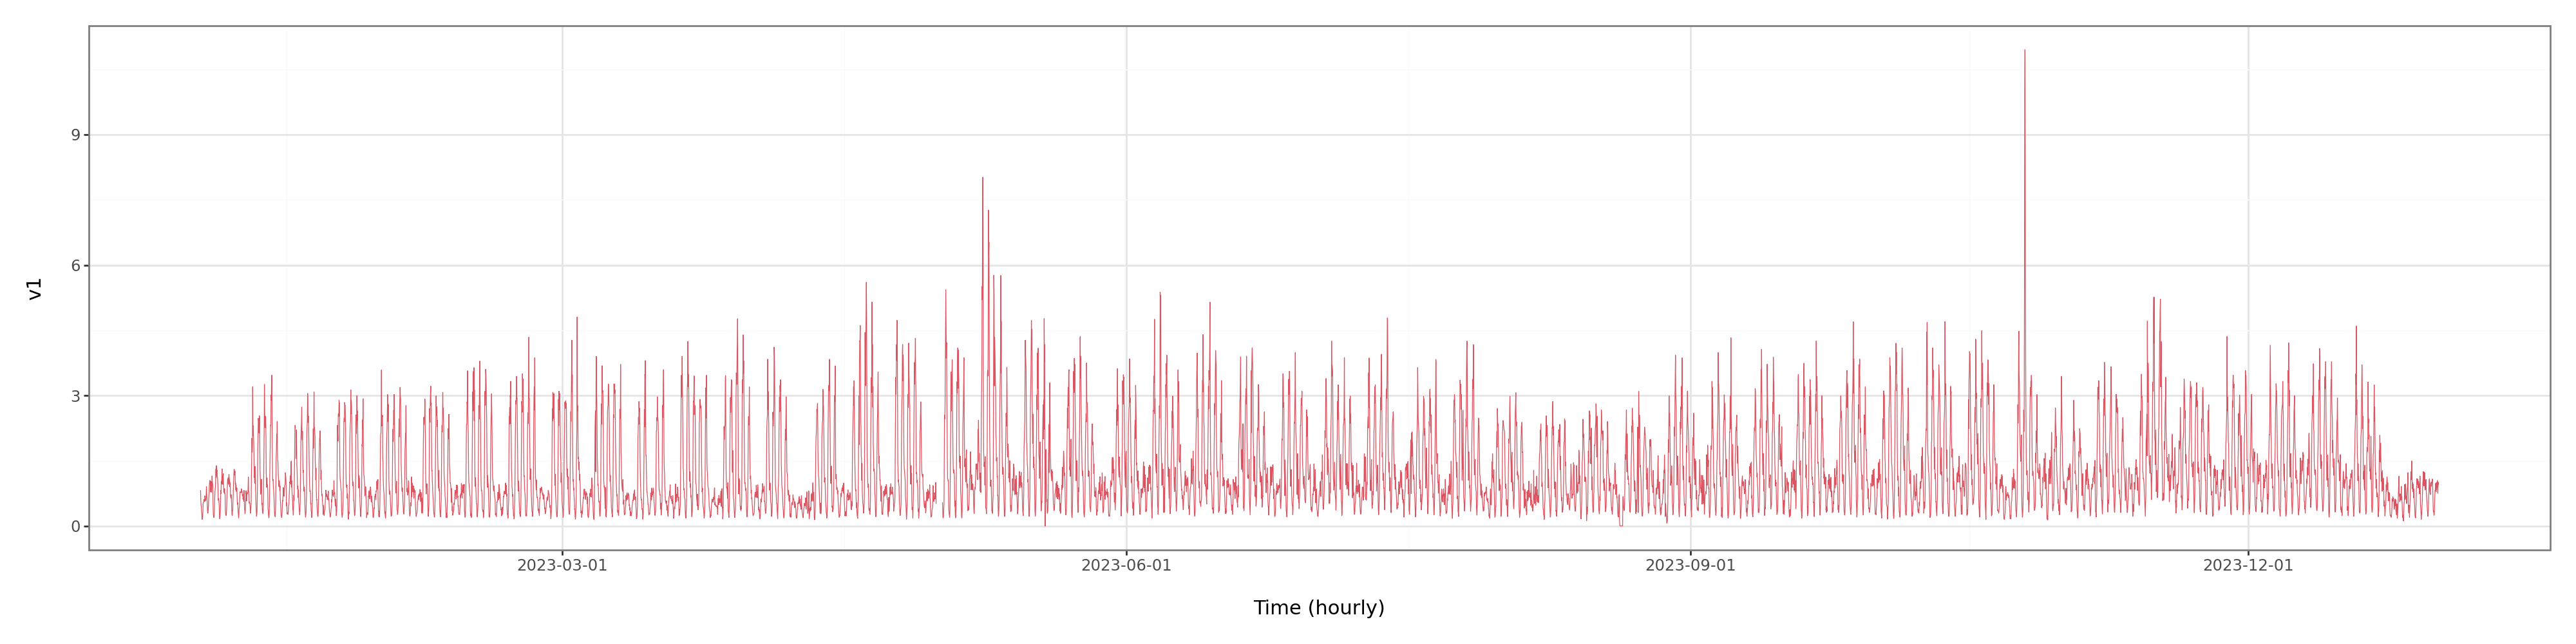

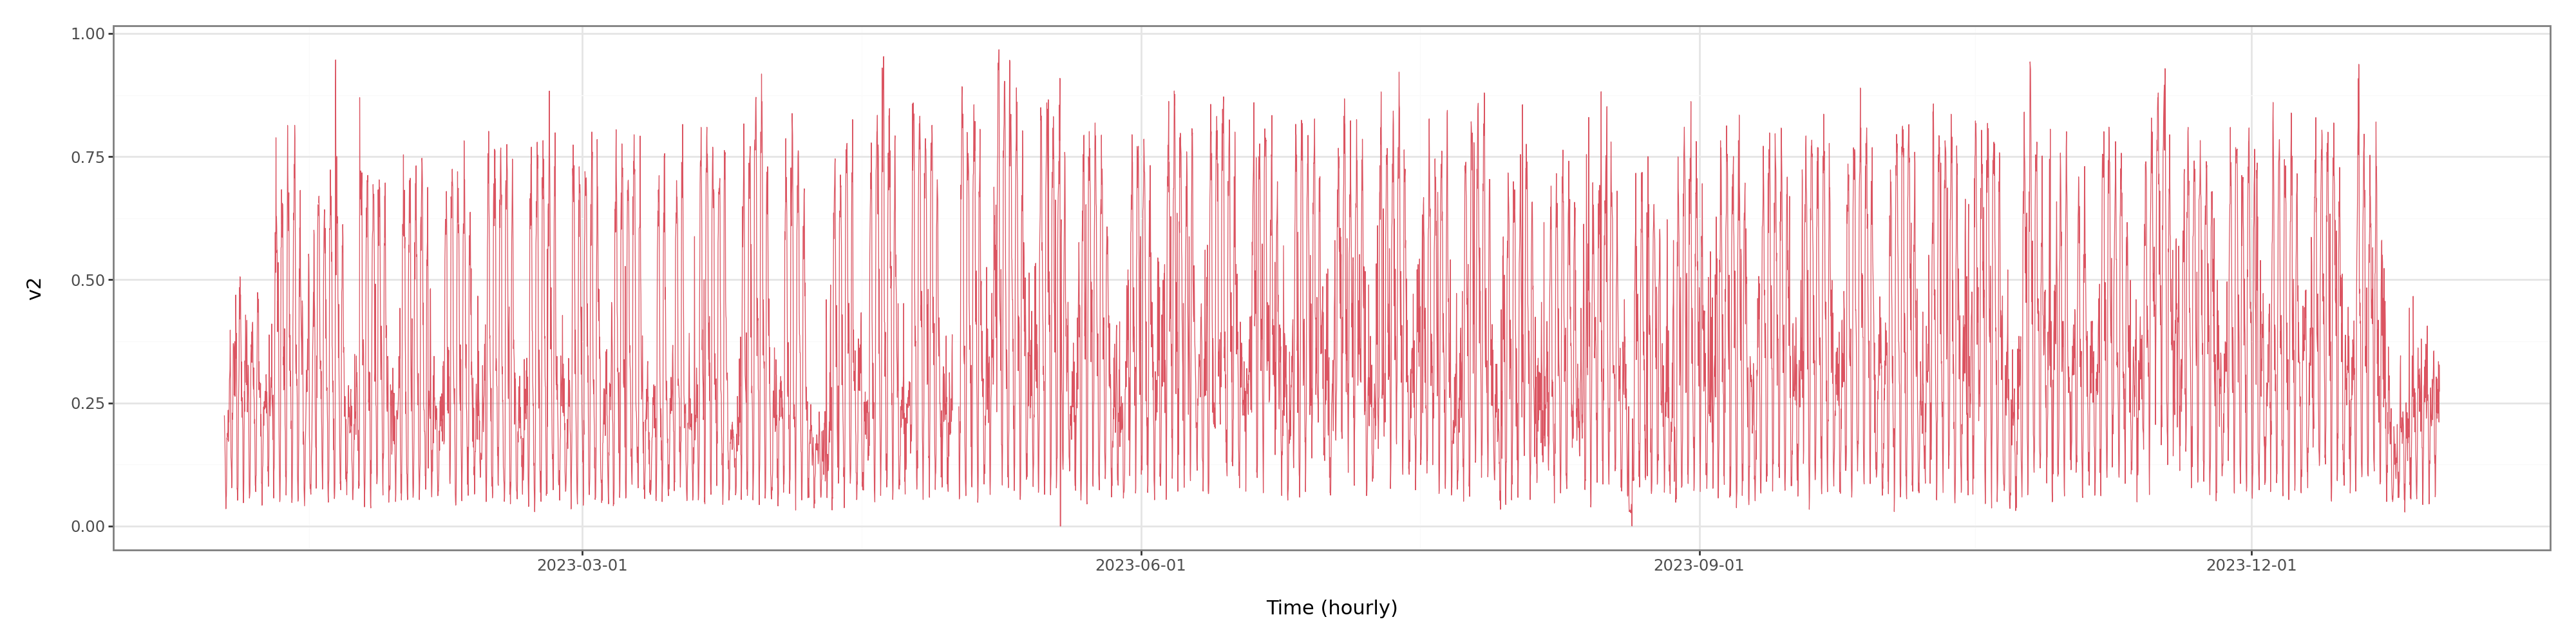

In [165]:
display(
    ggplot(data[data['year'] == 2023], aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)
display(
    ggplot(data[data['year'] == 2023], aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)

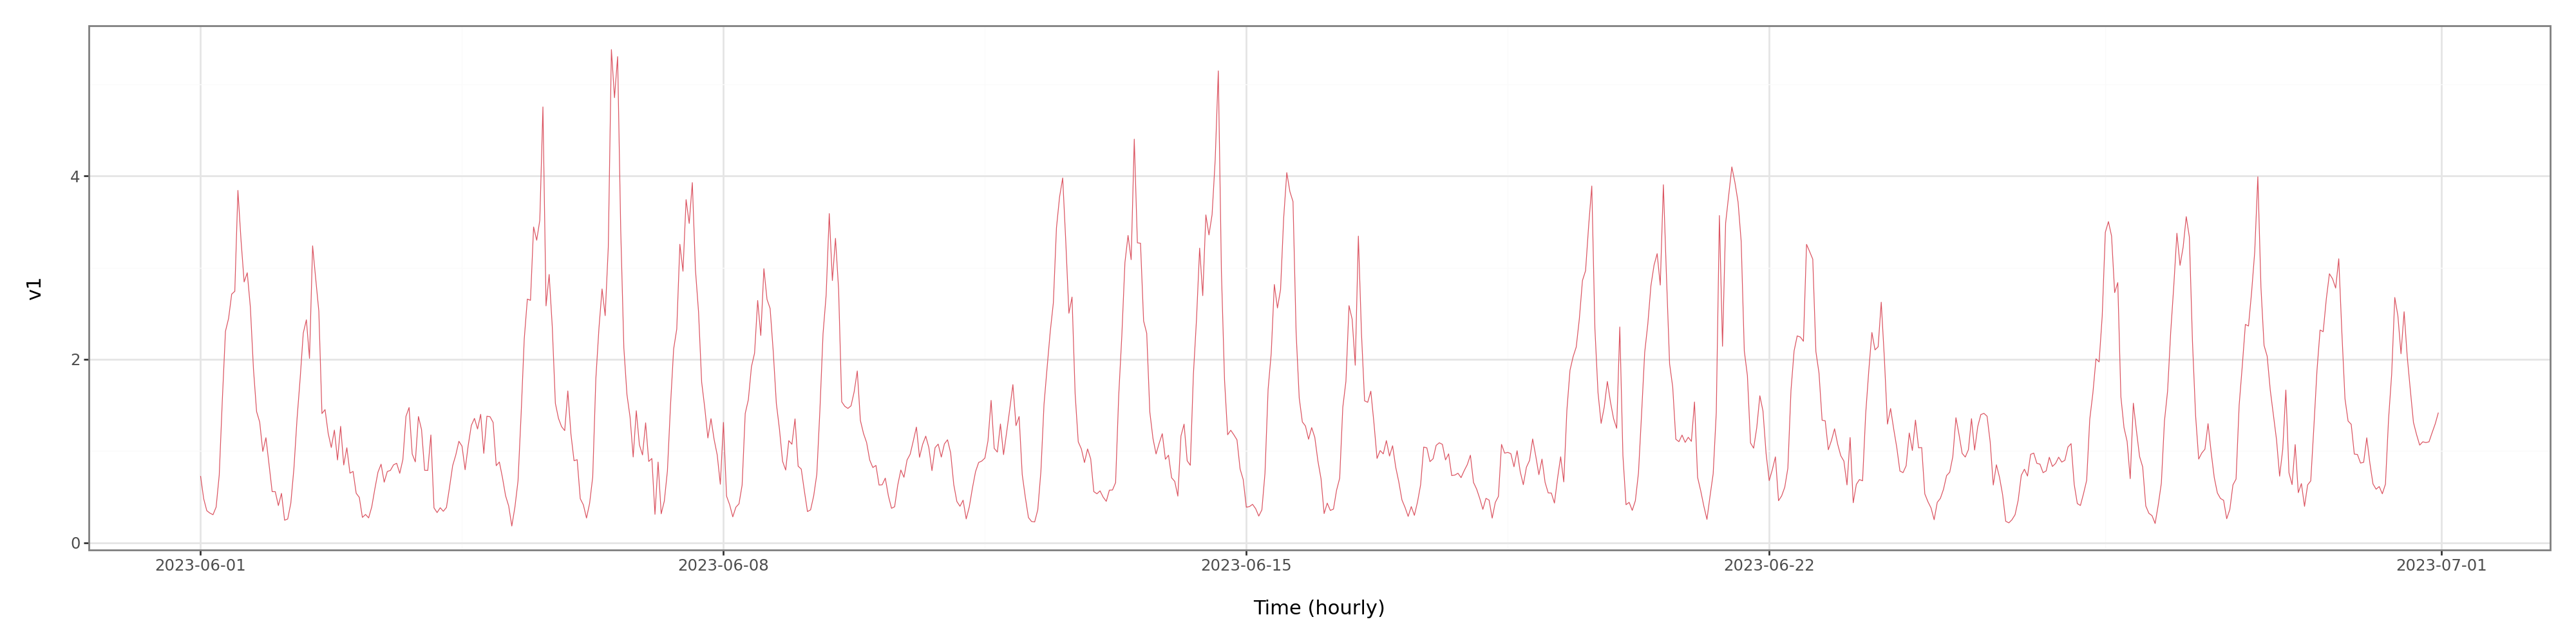

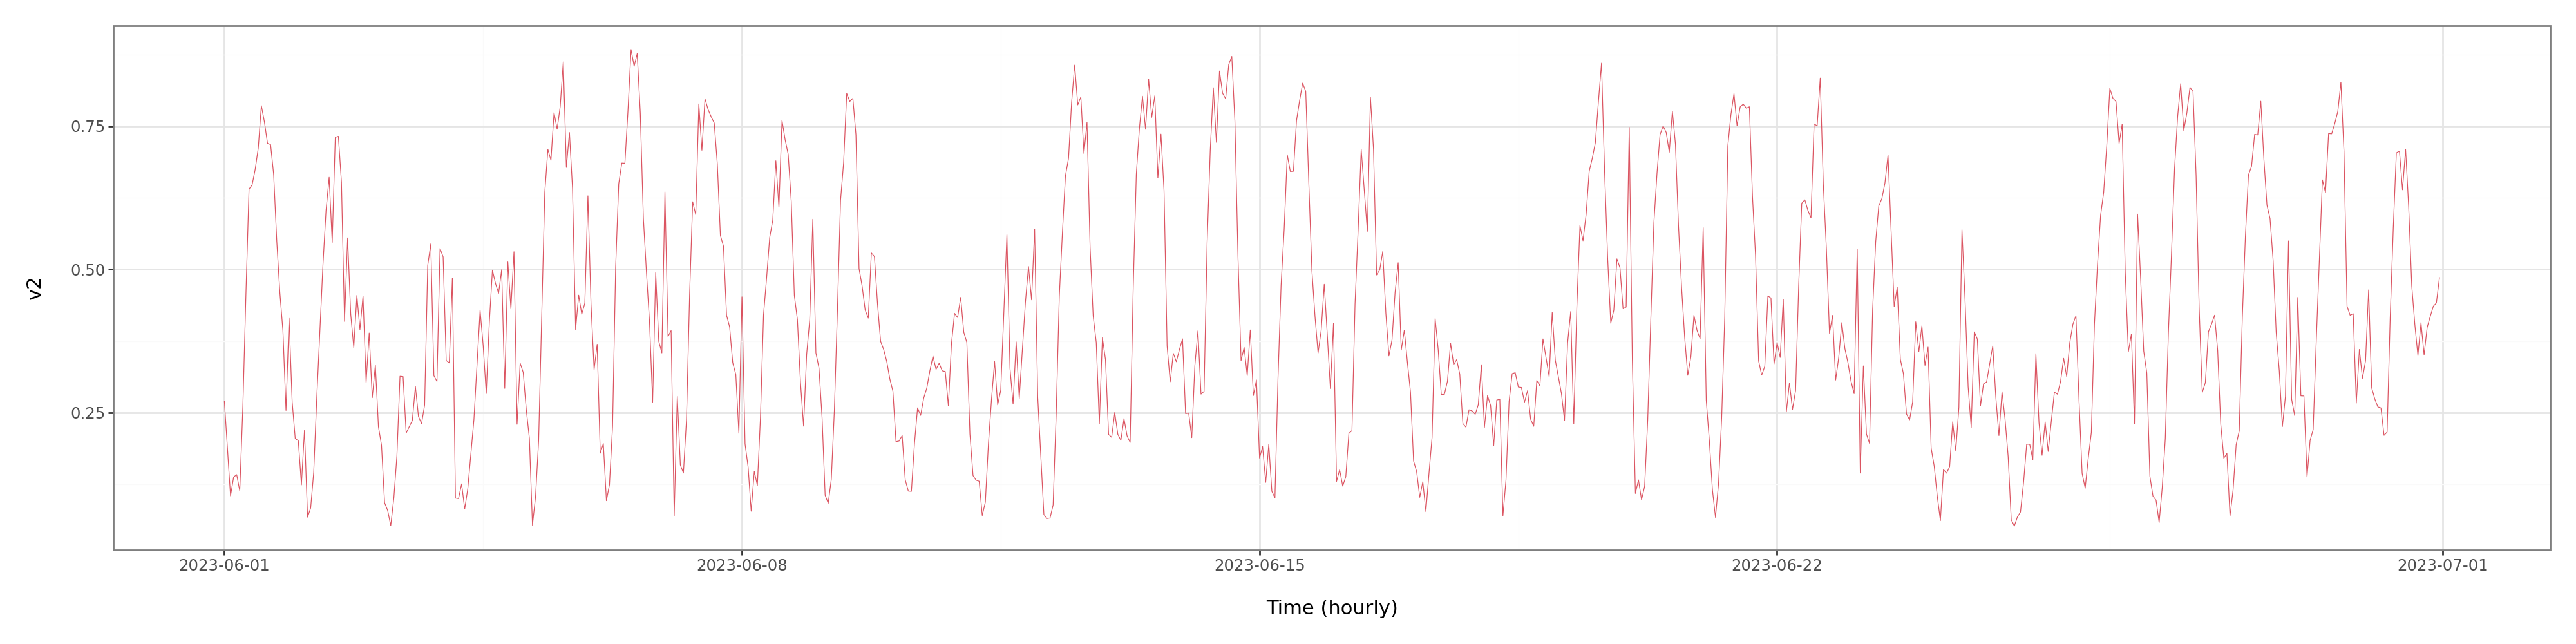

In [166]:
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6)], aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6)], aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)

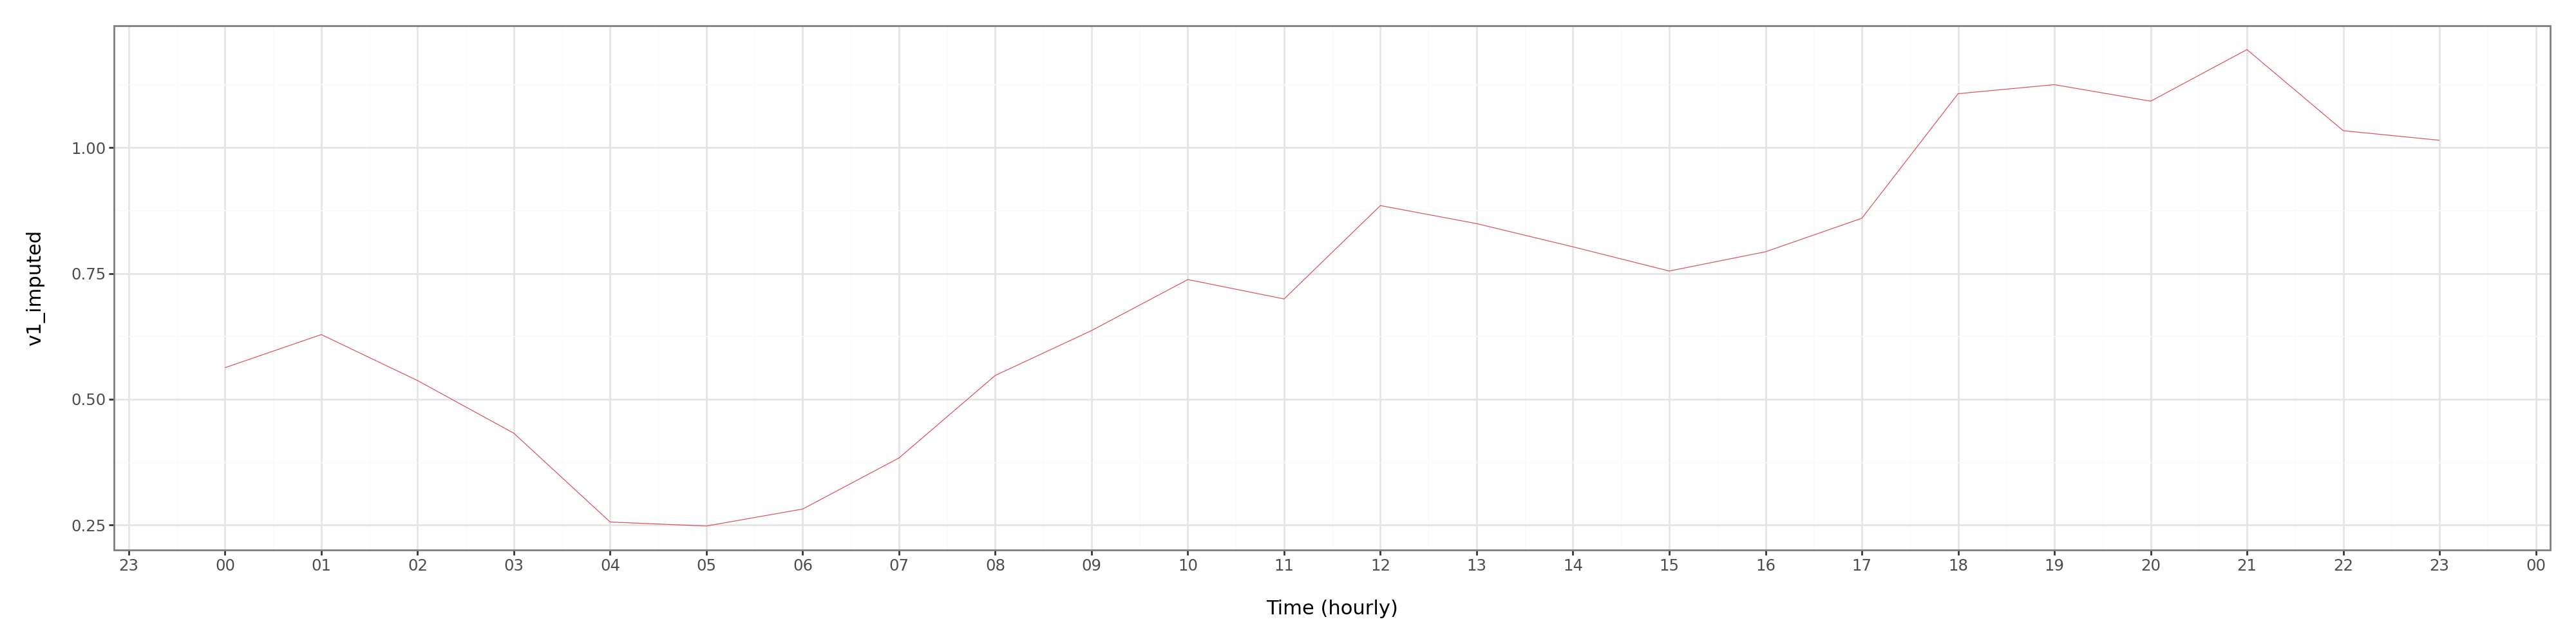

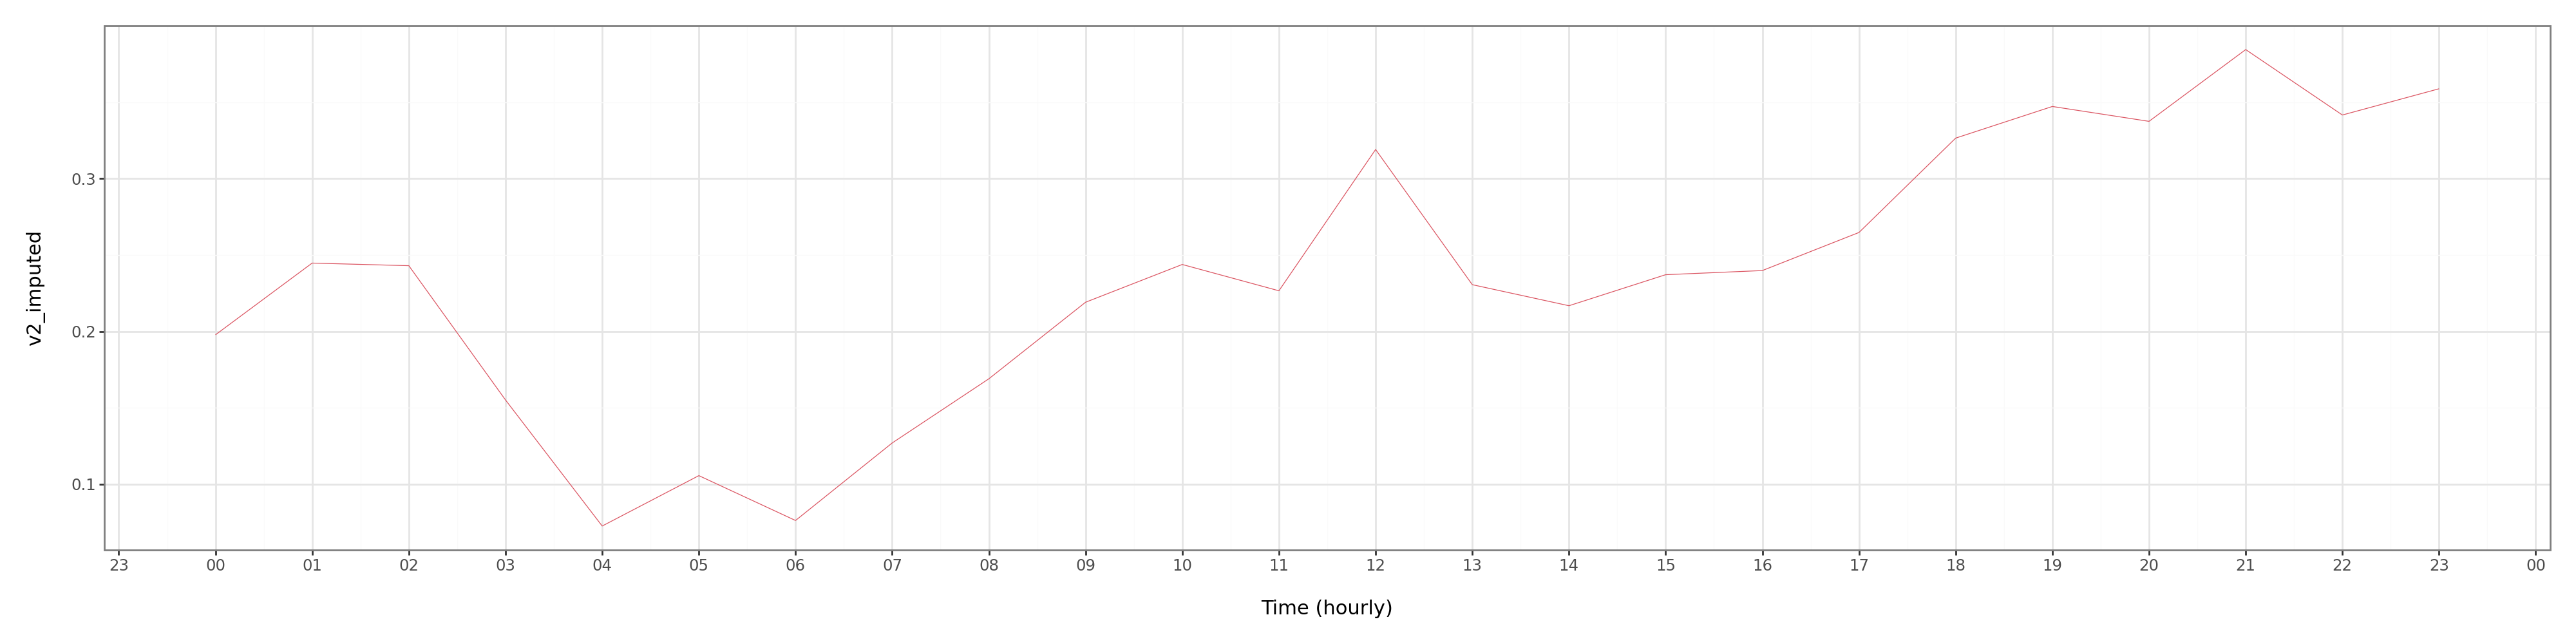

In [ ]:
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6) & (data['day'] == 15)], aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + scale_x_datetime(date_breaks='1 hour', date_labels='%H')
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6) & (data['day'] == 15)], aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + scale_x_datetime(date_breaks='1 hour', date_labels='%H')
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)

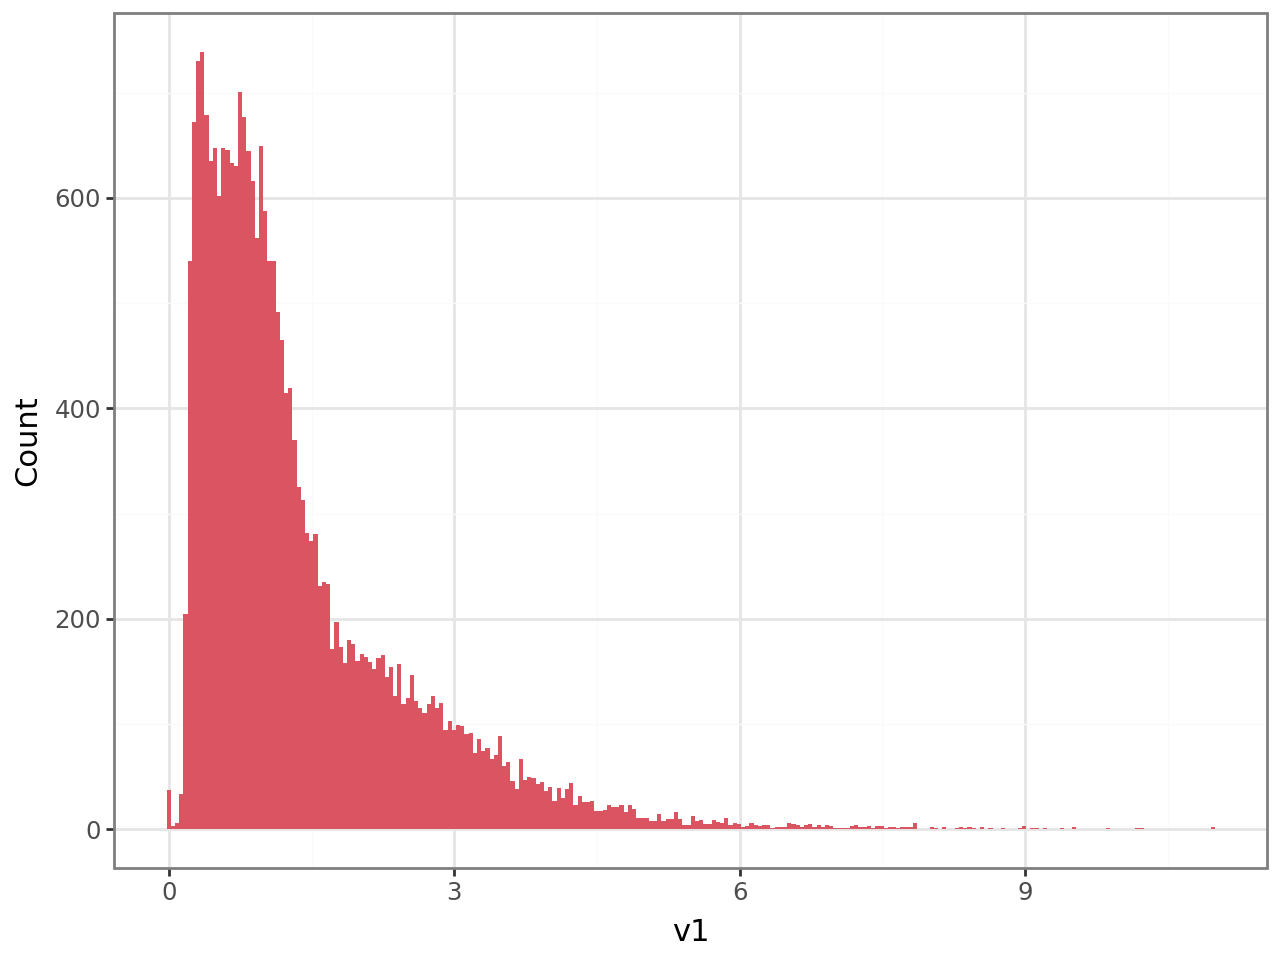

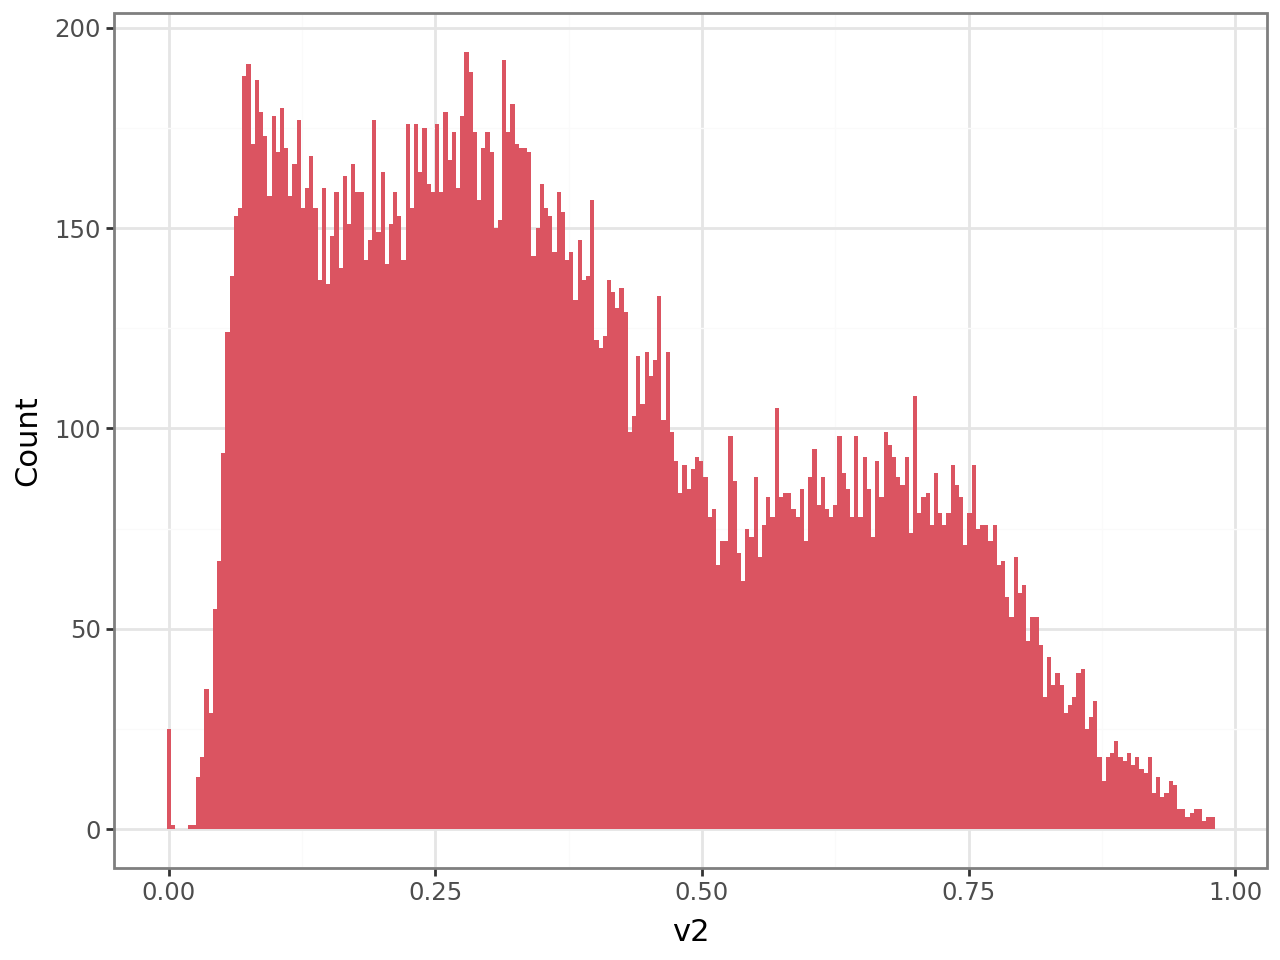

In [167]:
display(
    ggplot(data, aes(x = 'v1'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

display(
    ggplot(data, aes(x = 'v2'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

In [168]:
data[['v1', 'v2']].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]).T.round(4)

count    mean     std  min      1%      5%     10%     25%     50%  \
v1  24592.0  1.3858  1.1546  0.0  0.1933  0.2694  0.3433  0.5927  1.0170   
v2  24592.0  0.3808  0.2261  0.0  0.0492  0.0756  0.1033  0.1949  0.3399   

       75%     90%     95%     99%      max  
v1  1.8211  2.9795  3.6918  5.3872  10.9699  
v2  0.5543  0.7239  0.7864  0.8881   0.9789

In [199]:
data['ln_v1'] = data['v1'].apply(lambda x: np.nan if pd.isna(x) else np.log1p(x))
data['ln_v2'] = data['v2'].apply(lambda x: np.nan if pd.isna(x) else np.log1p(x))
data['ln_v1_imputed'] = np.log1p(data['v1_imputed'])
data['ln_v2_imputed'] = np.log1p(data['v2_imputed'])

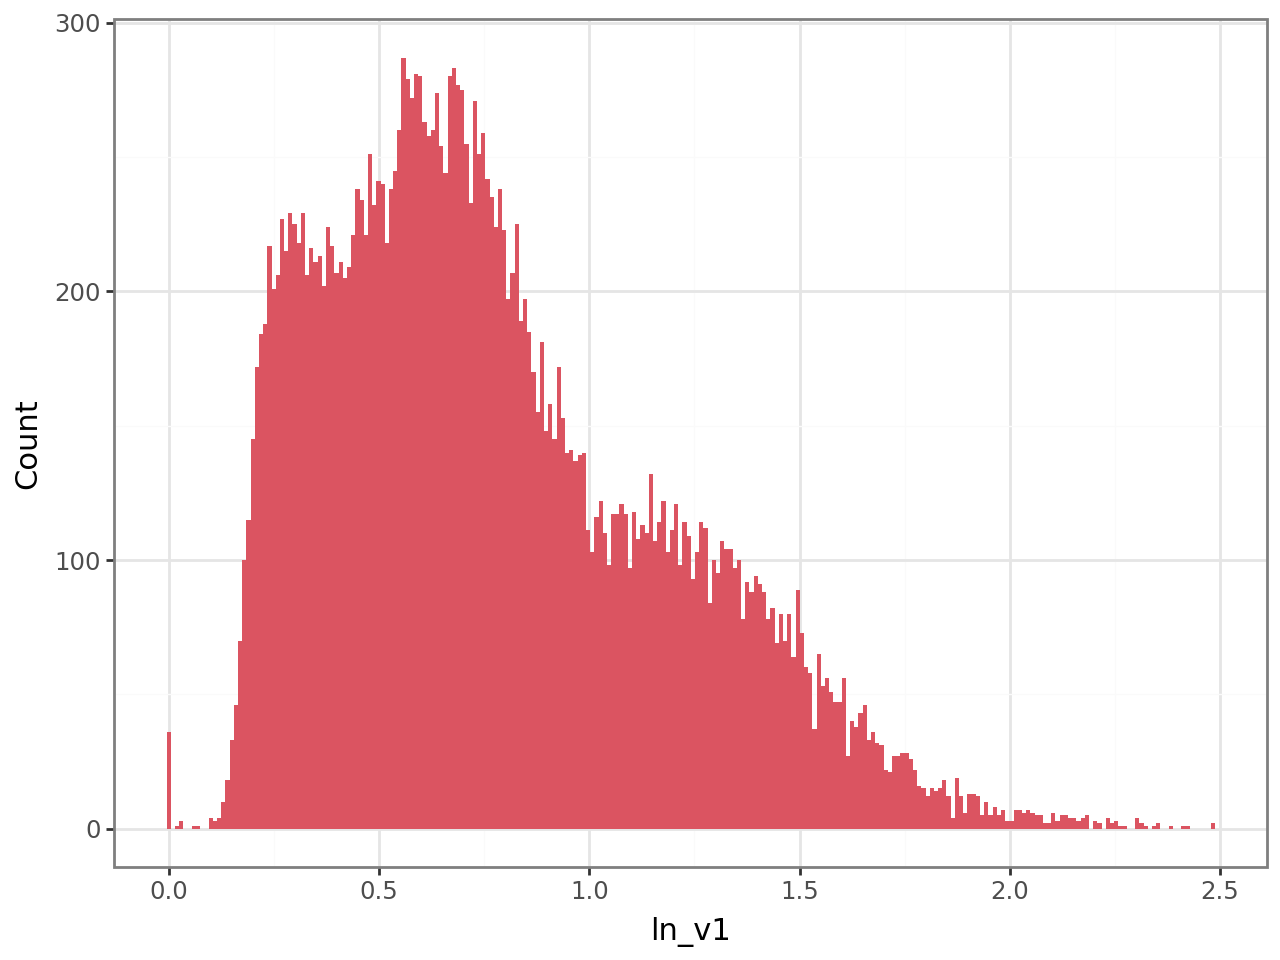

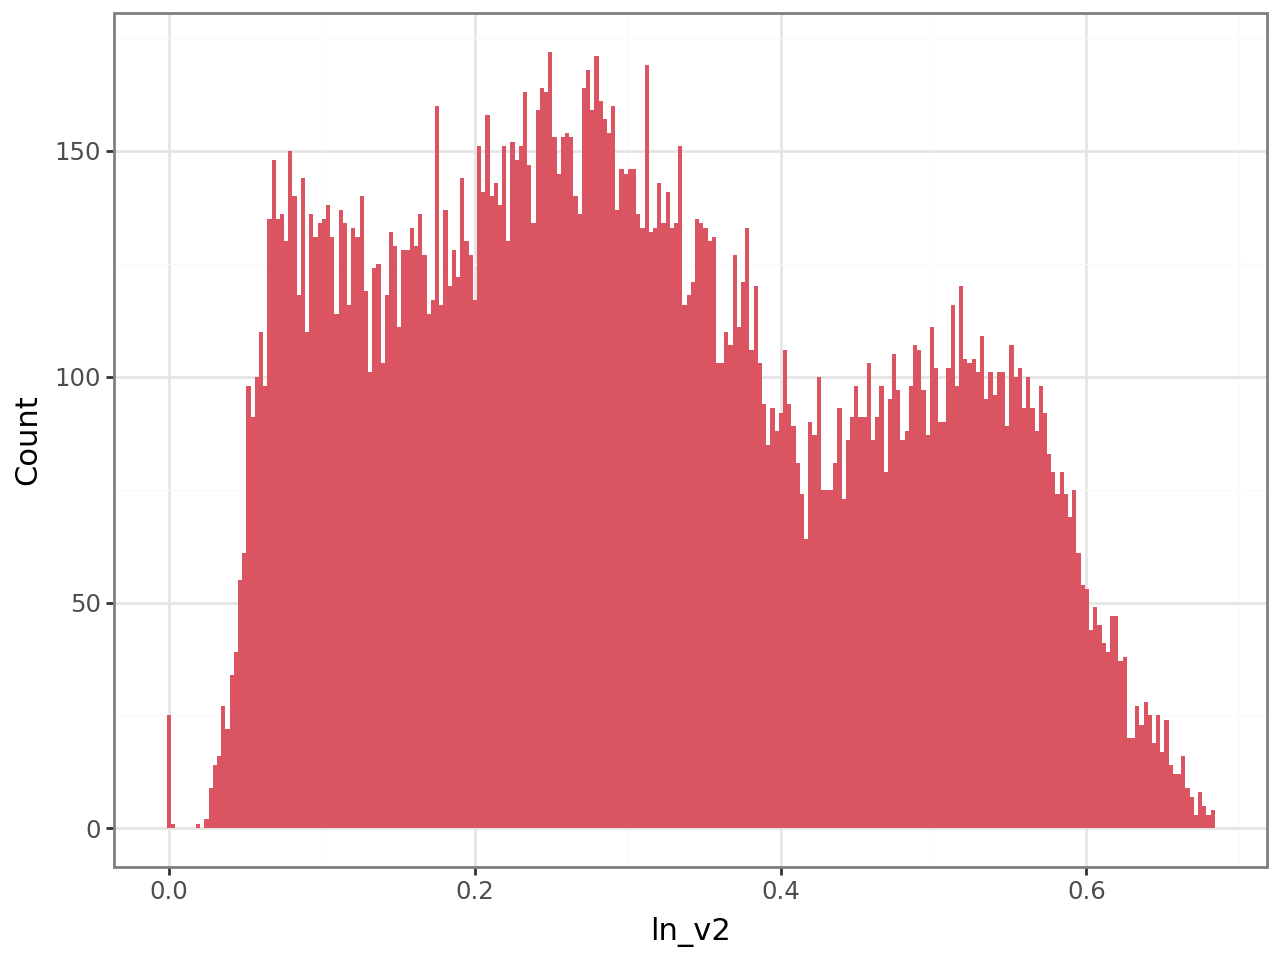

In [200]:
display(
    ggplot(data, aes(x = 'ln_v1'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

display(
    ggplot(data, aes(x = 'ln_v2'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

In [201]:
data['d_v1'] = data['v1'] - data['v1'].shift(1)
data['d_v2'] = data['v2'] - data['v2'].shift(1)
data['d_ln_v1'] = data['ln_v1'] - data['ln_v1'].shift(1)
data['d_ln_v2'] = data['ln_v2'] - data['ln_v2'].shift(1)
data['d_v1_imputed'] = data['v1_imputed'] - data['v1_imputed'].shift(1)
data['d_v2_imputed'] = data['v2_imputed'] - data['v2_imputed'].shift(1)
data['d_ln_v1_imputed'] = data['ln_v1_imputed'] - data['ln_v1_imputed'].shift(1)
data['d_ln_v2_imputed'] = data['ln_v2_imputed'] - data['ln_v2_imputed'].shift(1)

In [ ]:
data = data.set_index('ts')
mstl_v1 = MSTL(data['v1_imputed'], periods=(24, 24*7, 24*7*12)).fit()
mstl_v2 = MSTL(data['v2_imputed'], periods=(24, 24*7, 24*7*12)).fit()
data.reset_index(inplace=True)

In [195]:
v1_stat_test = adfuller(mstl_v1.resid, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
v2_stat_test = adfuller(mstl_v2.resid, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print('ADF stationarity test:\n    H0: Process is non-stationary (unit root present).\n    H1: Process is stationary.')
print('Note: variables cleaned from trend and hourly, weekly and monthly seasonality by MSTL, ADF results for residuals.')
print(f'v1 (imputed) p-value: {v1_stat_test[1]:.4f}')
print(f'v2 (imputed) p-value: {v2_stat_test[1]:.4f}')

ADF stationarity test:
    H0: Process is non-stationary (unit root present).
    H1: Process is stationary.
Note: variables cleaned from trend and hourly, weekly and monthly seasonality by MSTL, ADF results for residuals.
v1 (imputed) p-value: 0.0000
v2 (imputed) p-value: 0.0000
